# Planning Report — Predicting Usage of a Video Game Research Server
**Student:** Ansh Taparia 

**Project:** UBC Data Science Project  
**Student ID:** 32652604 

This notebook is fully reproducible.


In [75]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

In [76]:
set.seed(160)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

players 
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


## Data Description

The dataset `players.csv` contains one row per player and describes individual player characteristics and activity levels in the game.  

Each player has information such as:
- **experience** – the player’s skill level or familiarity with the game (Amateur, Veteran, or Pro).  
- **subscribe** – whether the player subscribed to the newsletter (TRUE/FALSE), which is our **response variable**.  
- **hashedEmail** – a unique player ID.  
- **played_hours** – the total number of hours each player has spent in the game.  
- **name** 
- **gender**  
- **Age**
 
From this, we are only using the `players.csv` dataset and not the `sessions.csv`. We look at how the **mean**, **standard deviation (sd)**, and **median** of the two numerical variables — `Age` and `played_hours` — describe the overall player base.


In [77]:
ph <- players |>
  summarise(
    mean = round(mean(played_hours, na.rm = TRUE), 2),
    median = round(median(played_hours, na.rm = TRUE), 2),
    sd = round(sd(played_hours, na.rm = TRUE), 2)
  ) |>
  pivot_longer(everything(), names_to = "stat", values_to = "value") |>
  mutate(variable = "played_hours")

ag <- players |>
  summarise(
    mean = round(mean(Age, na.rm = TRUE), 2),
    median = round(median(Age, na.rm = TRUE), 2),
    sd = round(sd(Age, na.rm = TRUE), 2)
  ) |>
  pivot_longer(everything(), names_to = "stat", values_to = "value") |>
  mutate(variable = "Age")

players_stats <- rbind(ph, ag) |>
  arrange(variable, stat)

players_stats

stat,value,variable
<chr>,<dbl>,<chr>
mean,21.14,Age
median,19.00,Age
sd,7.39,Age
mean,5.85,played_hours
median,0.10,played_hours
sd,28.36,played_hours


## Questions

**Broad question:**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question (players.csv only):**  
Can a player’s **experience**, **Age**, **gender**, and **played_hours** predict whether they **subscribe** to the newsletter?  
How do these features differ between **experience** groups (Amateur, Veteran, Pro)?



## Exploratory Data Analysis (EDA)

I explore three key visualizations that connect player traits to subscription status:

1. **Subscription Rate by Experience:**  
   This shows how likely different player types (Amateur, Veteran, Pro) are to subscribe.  

2. **Played Hours by Subscription:**  
   This checks if players who spend more time in the game are more likely to subscribe.  
 

3. **Age vs. Played Hours, Coloured by Subscription:**  
   This explores whether both age and playtime together influence who subscribes.  

In [78]:
rate_by_exp <- players |>
  group_by(experience) |>
  summarise(sub_rate = mean(subscribe, na.rm = TRUE))

ggplot(rate_by_exp, aes(x = (experience, sub_rate), y = sub_rate)) +
  geom_col() +
  coord_flip() +
  labs(title = "Subscription Rate by Experience",
       x = "Experience", y = "Subscription rate")


ERROR: Error in parse(text = x, srcfile = src): <text>:5:40: unexpected ','
4: 
5: ggplot(rate_by_exp, aes(x = (experience,
                                          ^


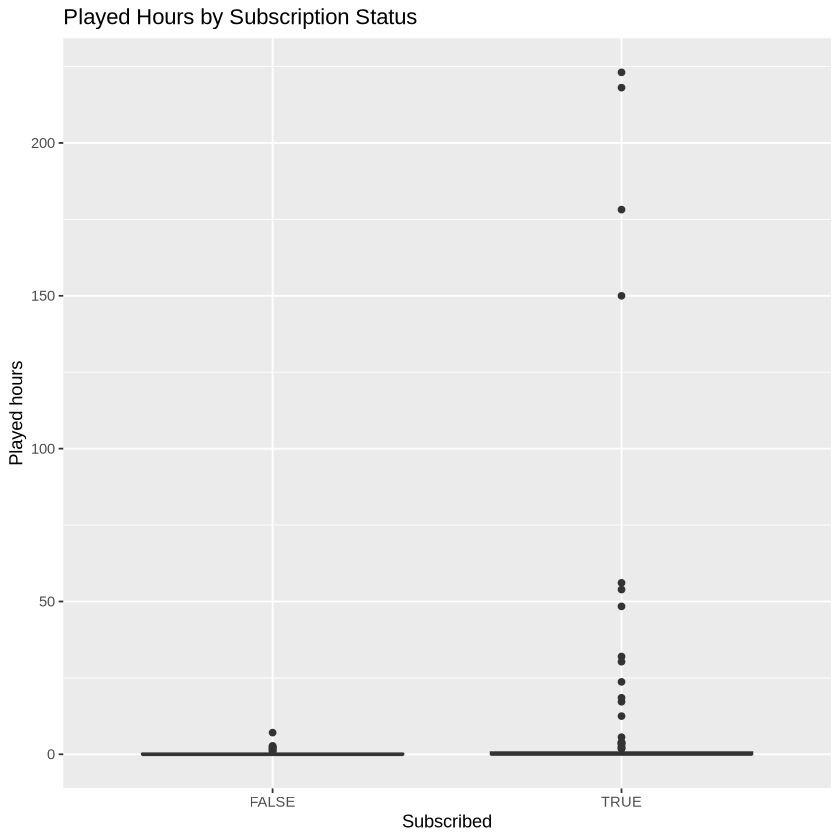

In [79]:
ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(title = "Played Hours by Subscription Status",
       x = "Subscribed", y = "Played hours")

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


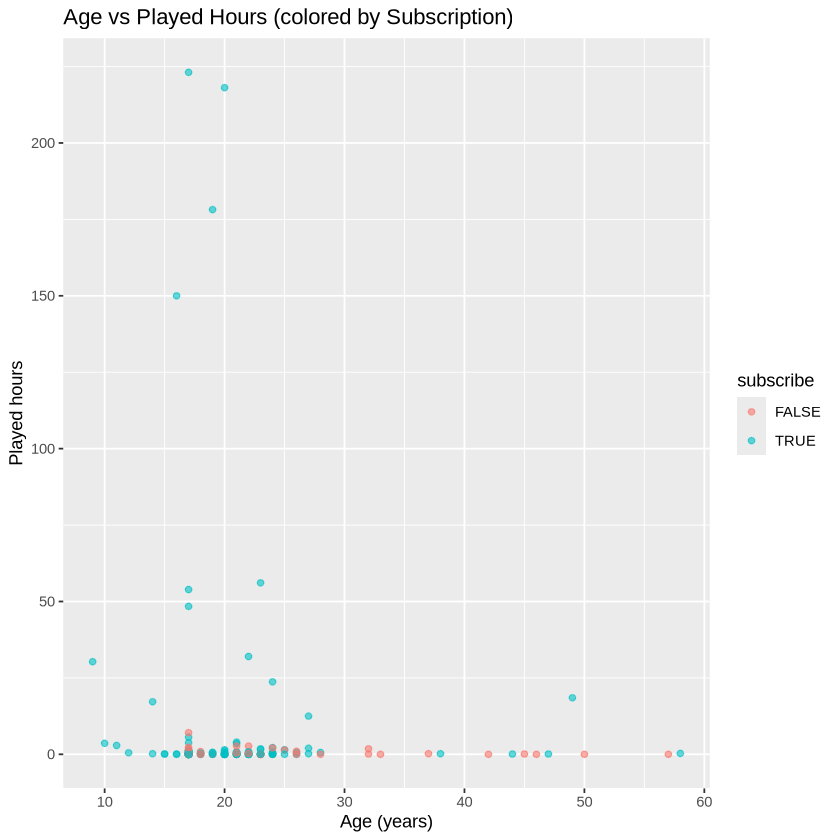

In [80]:
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Age vs Played Hours (colored by Subscription)",
       x = "Age (years)", y = "Played hours")

### Insights

From these plots, several trends appear:
- **Experienced players** (Veterans and Pros) have noticeably higher subscription rates than Amateurs.  
- **Subscribers** generally spend more hours playing than non-subscribers, suggesting engagement predicts interest in the newsletter.  
- The scatterplot shows that **younger and middle-aged players** who spend more time in the game are more likely to subscribe, while less active or older players are less represented among subscribers.



## Methods and Plan

**Goal.** Predict whether a player subscribes to the newsletter (TRUE/FALSE) using traits in `players.csv`.

**Method.** Logistic regression (classification).  
**Response:** `subscribe`  
**Predictors:** `experience`, `gender`, `Age`, `played_hours`

**Why this method?**  
Logistic regression is chosen because it models a binary outcome and is easy to interpret. It estimates the probability that a player subscribes based on their characteristics, while keeping the model simple. 

**Key assumptions.**  
This method assumes that each observation (player) is independent, and there is a linear relationship between the independent variables and the log-odds of the outcome. Assumes that the independent variables are not too highly correlated with each other. 

**Limitations.**  
A few challenges may affect the results. Missing values in the Age column could reduce the amount of usable data, and differences in how players report their information might add inaccuracy. The variable `played_hours` is likely right-skewed, meaning a few players have much higher values than most others, which may impact the model fit. 

**How the model will be compared and selected.**  
Before fitting the model, all numeric predictors, such as `age` and `played hours`, will be standardized so that they are on a comparable scale. Standardizing the data ensures that no single variable dominates the model due to having larger numeric values.

**How the data will be processed to apply the model.**  
Before fitting the model, I will prepare the data by converting categorical variables such as experience and gender into factor types and by imputing missing age values with the median. To prevent data leakage, imputation will be done within the training set during cross-validation. The dataset will be split into training and testing sets. If the subscription variable is unbalanced, a stratified split will be used so that both classes are represented fairly in both subsets.

## Word Count 

**Word Count** : 555